<a href="https://colab.research.google.com/github/mostafa-ja/mal_adv3/blob/main/2_DNN_model_drebin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader,WeightedRandomSampler
from sklearn.model_selection import train_test_split
from scipy import sparse
import gdown
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,balanced_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import time
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
download_links = ['https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_0.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_1.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_2.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y0.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y1.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y2.npz'
]

In [ ]:
output_filepath = '/content/'
for link in download_links:
  gdown.download(link, output_filepath)


Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_0.npz
To: /content/sparse_matrix_0.npz
100%|██████████| 461k/461k [00:00<00:00, 6.80MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_1.npz
To: /content/sparse_matrix_1.npz
100%|██████████| 148k/148k [00:00<00:00, 3.69MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_2.npz
To: /content/sparse_matrix_2.npz
100%|██████████| 150k/150k [00:00<00:00, 5.56MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y0.npz
To: /content/sparse_matrix_y0.npz
100%|██████████| 5.79k/5.79k [00:00<00:00, 16.1MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y1.npz
To: /content/sparse_matrix_y1.npz
100%|██████████| 2.64k/2.64k [00:00<00:00, 8.75MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/sparse_matrix_y2

In [ ]:
# Load dataset
X_train = sparse.load_npz("/content/sparse_matrix_0.npz").toarray()
X_val = sparse.load_npz("/content/sparse_matrix_1.npz").toarray()
X_test = sparse.load_npz("/content/sparse_matrix_2.npz").toarray()

X_train = torch.tensor(X_train, dtype=torch.int8)
X_val = torch.tensor(X_val, dtype=torch.int8)
X_test = torch.tensor(X_test, dtype=torch.int8)


y_train = sparse.load_npz("/content/sparse_matrix_y0.npz").toarray().reshape((-1, 1))
y_val = sparse.load_npz("/content/sparse_matrix_y1.npz").toarray().reshape((-1, 1))
y_test = sparse.load_npz("/content/sparse_matrix_y2.npz").toarray().reshape((-1, 1))

y_train = torch.tensor(y_train, dtype=torch.int8)
y_val = torch.tensor(y_val, dtype=torch.int8)
y_test = torch.tensor(y_test, dtype=torch.int8)


print("Shapes:")
print("x_train:", X_train.shape)
print("x_val:", X_val.shape)
print("x_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)


Shapes:
x_train: torch.Size([28683, 10000])
x_val: torch.Size([9562, 10000])
x_test: torch.Size([9562, 10000])
y_train: torch.Size([28683, 1])
y_val: torch.Size([9562, 1])
y_test: torch.Size([9562, 1])


In [ ]:
def weight_sampler(labels_train):

    # count occurance of each class
    labels_train = labels_train
    unique, counts = np.unique(labels_train, return_counts=True)

    # calcuate weight of each class
    class_weights = [1.0/c for c in counts]

    # assign weight to each sample
    sample_weights = [class_weights[i] for i in labels_train]

    # Create WeightedRandomSampler
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    return sampler

In [ ]:
# number of benigns and malicious sample in training dataset
n_ben = (y_train.squeeze()== 0).sum().item()
n_mal = (y_train.squeeze()== 1).sum().item()

# Combine features and labels into datasets
# we use dtype=torch.int8, for Memory-Efficient here, later we will convert to float
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Define the DataLoader for training, validation, and test sets
batch_size = 128
#sampler = weight_sampler(y_train)
#train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler=sampler)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Clear unnecessary variables
#del X_redefined, labels_tensor, X_train_val, X_test, labels_train_val, labels_test, X_train, X_val, labels_train, labels_val

In [ ]:
n_mal/(n_mal+n_ben)

0.11386535578565701

In [ ]:
class MalwareDetectionModel(nn.Module):
    def __init__(self, input_size=10000, hidden_1_size=200, hidden_2_size=200, num_labels=2, dropout_prob=0.6):
        super(MalwareDetectionModel, self).__init__()

        self.input_size = input_size
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.num_labels = num_labels
        self.dropout_prob = dropout_prob

        self.fc1 = nn.Linear(input_size, hidden_1_size)
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_2_size, num_labels)
        #self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        #x = self.log_softmax(x)
        return x


In [ ]:
model = MalwareDetectionModel()
model = model.to(device)
model

MalwareDetectionModel(
  (fc1): Linear(in_features=10000, out_features=200, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=200, out_features=2, bias=True)
)

In [ ]:
def model_evaluation(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for X_batch, labels_batch in test_loader:
            X_batch, labels_batch = X_batch.to(torch.float32).to(device), labels_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.topk(outputs, k=1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels_batch.tolist())

    # Convert predictions and true labels to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate and print test accuracy
    accuracy = accuracy_score(true_labels, predictions)
    balanced_acc = balanced_accuracy_score(true_labels, predictions)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test balanced Accuracy: {balanced_acc:.4f}')

    # Calculate and print precision, recall, and F1-score
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    # Calculate and print true positives, true negatives, false positives, and false negatives
    TP = ((predictions == 1) & (true_labels == 1)).sum()
    TN = ((predictions == 0) & (true_labels == 0)).sum()
    FP = ((predictions == 1) & (true_labels == 0)).sum()
    FN = ((predictions == 0) & (true_labels == 1)).sum()

    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')

    # Calculate and print False Negative Rate (FNR) and False Positive Rate (FPR)
    FNR = (FN / (FN + TP)) * 100
    FPR = (FP / (FP + TN)) * 100

    print(f'False Negative Rate (FNR): {FNR:.4f}')
    print(f'False Positive Rate (FPR): {FPR:.4f}')


In [ ]:
def adjust_learning_rate(optimizer, epoch, lr_step=(30,40,45), lr_decay_ratio=0.2):
    """Adjust the learning rate based on the epoch number."""
    if epoch == 0:
        optimizer.param_groups[0]['lr'] /= 8
    elif epoch in [1, 2, 3]:  # in step five , we finish warm up ,and start normal learning rate
        optimizer.param_groups[0]['lr'] *= 2
    if epoch in lr_step: # in these steps , we are geting close to optimal point so we need to have shorter step
        optimizer.param_groups[0]['lr'] *= lr_decay_ratio
    return optimizer


In [ ]:
learning_rate = 0.001
weight_decay = 0.
num_epochs = 50
dropout = 0.6

# Assuming positive class (malware) is label 1
class_weights = torch.tensor([0.11, 0.89]).to(device)  # Adjust the weights based on the class distribution, higher weight for positive class

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_balanced_acc = 0.
best_epoch = 0

for i in range(num_epochs):
    model.train()
    losses = []
    optimizer = adjust_learning_rate(optimizer, i)

    for idx_batch, (x_train, y_train) in enumerate(train_loader):
        x_train, y_train = x_train.to(torch.float32).to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss_train = criterion(outputs, y_train.view(-1).long())
        loss_train.backward()
        optimizer.step()
        losses.append(loss_train.item())

    model.eval()
    balanced_acc_values = []

    with torch.no_grad():
        model_evaluation(model, val_loader, device)
        torch.save(model.state_dict(), f'model_DNN_drebin_imbalanced_epoch_{i+1}.pth')  # Save the model after each epoch

    print(f'Epoch: {i+1}/{num_epochs} | Training loss: {np.mean(losses):.4f}')
    print('----------------------------------------------------------')


Test Accuracy: 0.9628
Test balanced Accuracy: 0.9593
Precision: 0.7711
Recall: 0.9548
F1-score: 0.8531
True Positives (TP): 1034
True Negatives (TN): 8172
False Positives (FP): 307
False Negatives (FN): 49
False Negative Rate (FNR): 4.5245
False Positive Rate (FPR): 3.6207
Epoch: 1/50 | Training loss: 0.3964
----------------------------------------------------------
Test Accuracy: 0.9747
Test balanced Accuracy: 0.9757
Precision: 0.8298
Recall: 0.9769
F1-score: 0.8974
True Positives (TP): 1058
True Negatives (TN): 8262
False Positives (FP): 217
False Negatives (FN): 25
False Negative Rate (FNR): 2.3084
False Positive Rate (FPR): 2.5593
Epoch: 2/50 | Training loss: 0.0981
----------------------------------------------------------
Test Accuracy: 0.9884
Test balanced Accuracy: 0.9798
Precision: 0.9316
Recall: 0.9686
F1-score: 0.9498
True Positives (TP): 1049
True Negatives (TN): 8402
False Positives (FP): 77
False Negatives (FN): 34
False Negative Rate (FNR): 3.1394
False Positive Rate (FP

KeyboardInterrupt: 

In [ ]:
# Load model parameters
for i in range(30):
  print('------------------------------------------------')
  print(f'model_DNN_drebin_imbalanced_epoch_{i+1}.pth')
  model_DNN_drebin_imbalanced = MalwareDetectionModel().to(device)
  model_DNN_drebin_imbalanced.load_state_dict(torch.load(f'model_DNN_drebin_imbalanced_epoch_{i+1}.pth', map_location=torch.device(device)))
  model_evaluation(model_DNN_drebin_imbalanced,test_loader,device=device)

------------------------------------------------
model_DNN_drebin_imbalanced_epoch_1.pth
Test Accuracy: 0.9614
Test balanced Accuracy: 0.9636
Precision: 0.7674
Recall: 0.9664
F1-score: 0.8555
True Positives (TP): 1092
True Negatives (TN): 8101
False Positives (FP): 331
False Negatives (FN): 38
False Negative Rate (FNR): 3.3628
False Positive Rate (FPR): 3.9255
------------------------------------------------
model_DNN_drebin_imbalanced_epoch_2.pth
Test Accuracy: 0.9727
Test balanced Accuracy: 0.9746
Precision: 0.8245
Recall: 0.9770
F1-score: 0.8943
True Positives (TP): 1104
True Negatives (TN): 8197
False Positives (FP): 235
False Negatives (FN): 26
False Negative Rate (FNR): 2.3009
False Positive Rate (FPR): 2.7870
------------------------------------------------
model_DNN_drebin_imbalanced_epoch_3.pth
Test Accuracy: 0.9868
Test balanced Accuracy: 0.9772
Precision: 0.9269
Recall: 0.9646
F1-score: 0.9454
True Positives (TP): 1090
True Negatives (TN): 8346
False Positives (FP): 86
False

balanced_accuracy_score however works differently in that it returns the average accuracy per class, which is a different metric. Say your 1000 labels are from 2 classes with 750 observations in class 1 and 250 in class 2. If you miss-predict 10 in each class, you have an accuracy of 740/750= 98.7% in class 1 and 240/250=96% in class 2. balanced_accuracy_score would then return (98.7%+96%)/2 = 97.35%. So I believe the program to work as expected, based on the documentation.

In [ ]:
import torch
from sklearn.metrics import balanced_accuracy_score

learning_rate = 0.001
weight_decay = 0.
num_epochs = 50
dropout = 0.6

# Assuming positive class (malware) is label 1
class_weights = torch.tensor([0.11, 0.89]).to(device)  # Adjust the weights based on the class distribution, higher weight for positive class

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_balanced_acc = 0.
best_epoch = 0

for i in range(num_epochs):
    model.train()
    losses = []
    #optimizer = adjust_learning_rate(optimizer, i)

    for idx_batch, (x_train, y_train) in enumerate(train_loader):
        x_train, y_train = x_train.to(torch.float32).to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss_train = criterion(outputs, y_train.view(-1).long())
        loss_train.backward()
        optimizer.step()
        losses.append(loss_train.item())

    model.eval()
    balanced_acc_values = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(torch.float32).to(device), y_val.to(device)
            outputs = model(x_val)
            predicted = outputs.argmax(1)
            balanced_acc = balanced_accuracy_score(y_val.cpu().numpy(), predicted.cpu().numpy())
            balanced_acc_values.append(balanced_acc)

    avg_balanced_acc = np.mean(balanced_acc_values)

    if avg_balanced_acc >= best_balanced_acc:
        best_balanced_acc = avg_balanced_acc
        best_epoch = i
        torch.save(model.state_dict(), 'model_DNN_drebin_imbalanced_balanced_acc.pth')

    print(f'Epoch: {i+1}/{num_epochs} | Training loss: {np.mean(losses):.4f} | Validation Balanced Accuracy: {avg_balanced_acc:.4f} | Best Validation Balanced Accuracy: {best_balanced_acc:.4f} at epoch: {best_epoch+1}')

print(f'Best Balanced Accuracy: {best_balanced_acc:.4f} | Best Epoch: {best_epoch+1}')


Epoch: 1/50 | Training loss: 0.1760 | Validation Balanced Accuracy: 0.9740 | Best Validation Balanced Accuracy: 0.9740 at epoch: 1
Epoch: 2/50 | Training loss: 0.0427 | Validation Balanced Accuracy: 0.9813 | Best Validation Balanced Accuracy: 0.9813 at epoch: 2
Epoch: 3/50 | Training loss: 0.0234 | Validation Balanced Accuracy: 0.9813 | Best Validation Balanced Accuracy: 0.9813 at epoch: 3
Epoch: 4/50 | Training loss: 0.0138 | Validation Balanced Accuracy: 0.9755 | Best Validation Balanced Accuracy: 0.9813 at epoch: 3
Epoch: 5/50 | Training loss: 0.0100 | Validation Balanced Accuracy: 0.9732 | Best Validation Balanced Accuracy: 0.9813 at epoch: 3
Epoch: 6/50 | Training loss: 0.0050 | Validation Balanced Accuracy: 0.9768 | Best Validation Balanced Accuracy: 0.9813 at epoch: 3
Epoch: 7/50 | Training loss: 0.0040 | Validation Balanced Accuracy: 0.9698 | Best Validation Balanced Accuracy: 0.9813 at epoch: 3
Epoch: 8/50 | Training loss: 0.0056 | Validation Balanced Accuracy: 0.9669 | Best V

In [ ]:
import torch
from sklearn.metrics import confusion_matrix

learning_rate = 0.001
weight_decay = 0.
num_epochs = 50
dropout = 0.6

# Assuming positive class (malware) is label 1
class_weights = torch.tensor([0.11, 0.89]).to(device)  # Adjust the weights based on the class distribution, higher weight for positive class

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_fnr = float('inf')
best_epoch = 0

for i in range(num_epochs):
    model.train()
    losses = []
    optimizer = adjust_learning_rate(optimizer, i)

    for idx_batch, (x_train, y_train) in enumerate(train_loader):
        x_train, y_train = x_train.to(torch.float32).to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss_train = criterion(outputs, y_train.view(-1).long())
        loss_train.backward()
        optimizer.step()
        losses.append(loss_train.item())

    model.eval()
    fnr_values = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(torch.float32).to(device), y_val.to(device)
            outputs = model(x_val)
            predicted = outputs.argmax(1)
            conf_matrix = confusion_matrix(y_val.cpu().numpy(), predicted.cpu().numpy())
            fnr = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])  # False Negative Rate
            fnr_values.append(fnr)

    avg_fnr = np.mean(fnr_values)

    if avg_fnr <= best_fnr:
        best_fnr = avg_fnr
        best_epoch = i
        torch.save(model.state_dict(), 'model_DNN_drebin_imbalanced_fnr.pth')

    print(f'Epoch: {i+1}/{num_epochs} | Training loss: {np.mean(losses):.4f} | Validation FNR: {avg_fnr:.4f} | Best Validation FNR: {best_fnr:.4f} at epoch: {best_epoch+1}')

print(f'Best FNR: {best_fnr:.4f} | Best Epoch: {best_epoch+1}')


Epoch: 1/50 | Training loss: 0.3928 | Validation FNR: 0.0586 | Best Validation FNR: 0.0586 at epoch: 1
Epoch: 2/50 | Training loss: 0.0998 | Validation FNR: 0.0307 | Best Validation FNR: 0.0307 at epoch: 2
Epoch: 3/50 | Training loss: 0.0474 | Validation FNR: 0.0287 | Best Validation FNR: 0.0287 at epoch: 3
Epoch: 4/50 | Training loss: 0.0416 | Validation FNR: 0.0385 | Best Validation FNR: 0.0287 at epoch: 3
Epoch: 5/50 | Training loss: 0.0265 | Validation FNR: 0.0279 | Best Validation FNR: 0.0279 at epoch: 5
Epoch: 6/50 | Training loss: 0.0129 | Validation FNR: 0.0326 | Best Validation FNR: 0.0279 at epoch: 5
Epoch: 7/50 | Training loss: 0.0097 | Validation FNR: 0.0742 | Best Validation FNR: 0.0279 at epoch: 5
Epoch: 8/50 | Training loss: 0.0089 | Validation FNR: 0.0594 | Best Validation FNR: 0.0279 at epoch: 5
Epoch: 9/50 | Training loss: 0.0140 | Validation FNR: 0.0553 | Best Validation FNR: 0.0279 at epoch: 5
Epoch: 10/50 | Training loss: 0.0053 | Validation FNR: 0.0522 | Best Vali

In [ ]:
learning_rate = 0.001
weight_decay = 0.
num_epochs = 50
dropout = 0.6

# Assuming positive class (malware) is label 1
class_weights = torch.tensor([0.11, 0.89]).to(device)  # Adjust the weights based on the class distribution, higher weight for positive class


# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_f1_score = 0.
best_epoch = 0
total_time = 0.
nbatches = len(train_loader)

for i in range(num_epochs):
    model.train()
    losses, f1_scores = [], []
    optimizer = adjust_learning_rate(optimizer, i)

    for idx_batch, (x_train, y_train) in enumerate(train_loader):
        x_train, y_train = x_train.to(torch.float32).to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss_train = criterion(outputs, y_train.view(-1).long())
        loss_train.backward()
        optimizer.step()

        predicted = (outputs.argmax(1)).unsqueeze(1)
        f1_train = f1_score(y_train.cpu().numpy(), predicted.cpu().numpy(), zero_division=1)

        losses.append(loss_train.item())
        f1_scores.append(f1_train)

    model.eval()
    avg_f1_val = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(torch.float32).to(device), y_val.to(device)
            outputs = model(x_val)
            predicted = (outputs.argmax(1)).unsqueeze(1)
            f1_val = f1_score(y_val.cpu().numpy(), predicted.cpu().numpy())
            avg_f1_val.append(f1_val)

    avg_f1_val = np.mean(avg_f1_val)

    if avg_f1_val >= best_f1_score:
        best_f1_score = avg_f1_val
        best_epoch = i
        torch.save(model.state_dict(), 'model_DNN_drebin_balancedWeight.pth')

    print(f'Epoch: {i+1}/{num_epochs} | Training loss: {np.mean(losses):.4f} | Validation F1-score: {avg_f1_val:.4f} | The best validation F1-score: {best_f1_score * 100:.2f} at epoch: {best_epoch+1}')

print(f'Best F1-score: {best_f1_score:.4f} | Best Epoch: {best_epoch+1}')


Epoch: 1/50 | Training loss: 0.3828 | Validation F1-score: 0.8496 | The best validation F1-score: 84.96 at epoch: 1
Epoch: 2/50 | Training loss: 0.0950 | Validation F1-score: 0.9311 | The best validation F1-score: 93.11 at epoch: 2
Epoch: 3/50 | Training loss: 0.0497 | Validation F1-score: 0.9448 | The best validation F1-score: 94.48 at epoch: 3
Epoch: 4/50 | Training loss: 0.0391 | Validation F1-score: 0.9536 | The best validation F1-score: 95.36 at epoch: 4
Epoch: 5/50 | Training loss: 0.0321 | Validation F1-score: 0.9657 | The best validation F1-score: 96.57 at epoch: 5
Epoch: 6/50 | Training loss: 0.0163 | Validation F1-score: 0.9649 | The best validation F1-score: 96.57 at epoch: 5
Epoch: 7/50 | Training loss: 0.0133 | Validation F1-score: 0.9144 | The best validation F1-score: 96.57 at epoch: 5
Epoch: 8/50 | Training loss: 0.0088 | Validation F1-score: 0.9636 | The best validation F1-score: 96.57 at epoch: 5
Epoch: 9/50 | Training loss: 0.0038 | Validation F1-score: 0.9674 | The 

In [ ]:
# Load model parameters
model_DNN_drebin_imbalanced_fnr = MalwareDetectionModel().to(device)
model_DNN_drebin_imbalanced_fnr.load_state_dict(torch.load('model_DNN_drebin_imbalanced_fnr.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
# Load model parameters
model_DNN_drebin_imbalanced_balanced_acc = MalwareDetectionModel().to(device)
model_DNN_drebin_imbalanced_balanced_acc.load_state_dict(torch.load('model_DNN_drebin_imbalanced_balanced_acc.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
# Load model parameters
model_DNN_drebin_balancedWeight = MalwareDetectionModel().to(device)
model_DNN_drebin_balancedWeight.load_state_dict(torch.load('model_DNN_drebin_balancedWeight.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
model_evaluation(model_DNN_drebin_imbalanced_fnr,test_loader,device=device)

Test Accuracy: 0.9905
Precision: 0.9537
Recall: 0.9664
F1-score: 0.9600
True Positives (TP): 1092
True Negatives (TN): 8379
False Positives (FP): 53
False Negatives (FN): 38
False Negative Rate (FNR): 3.3628
False Positive Rate (FPR): 0.6286


In [ ]:
model_evaluation(model_DNN_drebin_balancedWeight,test_loader,device=device)

Test Accuracy: 0.9919
Precision: 0.9765
Recall: 0.9549
F1-score: 0.9655
True Positives (TP): 1079
True Negatives (TN): 8406
False Positives (FP): 26
False Negatives (FN): 51
False Negative Rate (FNR): 4.5133
False Positive Rate (FPR): 0.3083


In [ ]:
model_evaluation(model_DNN_drebin_imbalanced_balanced_acc,test_loader,device=device)

Test Accuracy: 0.9922
Test balanced Accuracy: 0.9760
Precision: 0.9782
Recall: 0.9549
F1-score: 0.9664
True Positives (TP): 1079
True Negatives (TN): 8408
False Positives (FP): 24
False Negatives (FN): 51
False Negative Rate (FNR): 4.5133
False Positive Rate (FPR): 0.2846


In [ ]:
#here , we define prediction, as probability(not binary)

# Evaluate the trained model on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():
    for X_batch, labels_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.topk(outputs, k=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels_batch.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

# Calculate F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1-score
best_f1_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f'Best F1-score: {best_f1_score:.4f} at threshold: {best_f1_threshold:.4f}')


Best F1-score: 0.9200 at threshold: 1.0000


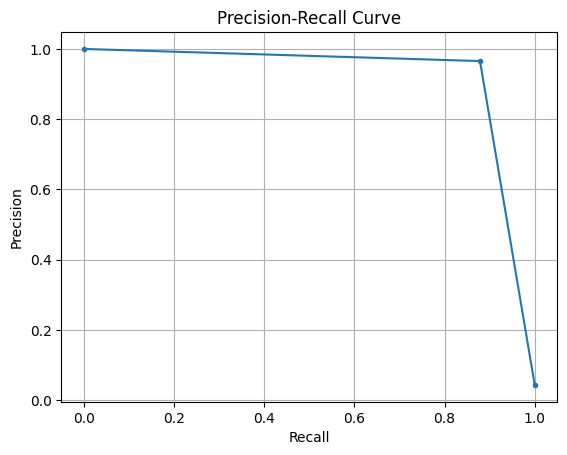

In [ ]:

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [ ]:
# Compute fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()